One of the standard global SST products is readily available from NOAA:
http://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.html.  We will use the monthly-averaged version.  We need two files: the actual SST, and the land mask.

In [2]:
%matplotlib inline

import os
import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from mpl_toolkits.basemap import Basemap

import netCDF4 as nc

from six.moves import urllib # six is for Python 2/3 compatibility

from pycurrents.codas import to_day
from pycurrents.num import rangeslice
from pycurrents.num import eof
# https://currents.soest.hawaii.edu/ocn_data_analysis/installation.html

In [4]:
fnames = ['sst.mnmean.nc', 'lsmask.nc']
urlbase = 'ftp://ftp.cdc.noaa.gov/Datasets/noaa.oisst.v2/'

for fname in fnames:
    if not os.path.exists(fname):
        urllib.request.urlretrieve(urlbase + fname, fname)
        
lsmasknc = nc.Dataset(fnames[1])

# strip the time dimension off the mask
seamask = lsmasknc.variables['mask'][0].astype(bool)
lsmasknc.close()
landmask = np.logical_not(seamask)
print(landmask.shape)

sstnc = nc.Dataset(fnames[0])

# Read all the 1-D dimensional arrays.
time = sstnc.variables['time'][:]
lat = sstnc.variables['lat'][:]                       
lon = sstnc.variables['lon'][:]

# Read the 3-D SST array, and mask it.
sst = np.ma.array(sstnc.variables['sst'][:])
sst[:, landmask] = np.ma.masked
sstnc.close()
time

(180, 360)


masked_array(data=[66443., 66474., 66505., 66533., 66564., 66594., 66625.,
                   66655., 66686., 66717., 66747., 66778., 66808., 66839.,
                   66870., 66898., 66929., 66959., 66990., 67020., 67051.,
                   67082., 67112., 67143., 67173., 67204., 67235., 67264.,
                   67295., 67325., 67356., 67386., 67417., 67448., 67478.,
                   67509., 67539., 67570., 67601., 67629., 67660., 67690.,
                   67721., 67751., 67782., 67813., 67843., 67874., 67904.,
                   67935., 67966., 67994., 68025., 68055., 68086., 68116.,
                   68147., 68178., 68208., 68239., 68269., 68300., 68331.,
                   68359., 68390., 68420., 68451., 68481., 68512., 68543.,
                   68573., 68604., 68634., 68665., 68696., 68725., 68756.,
                   68786., 68817., 68847., 68878., 68909., 68939., 68970.,
                   69000., 69031., 69062., 69090., 69121., 69151., 69182.,
                   69212.

In [3]:
dday2000 = time - to_day(1800, 2000, 1, 1, 0, 0, 0)
yeartime = 2000 + dday2000 / 365.25
print(yeartime[0], yeartime[-1])

1981.9164955509925 2018.6666666666667


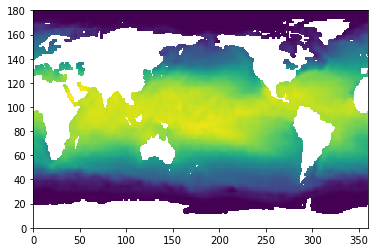

In [4]:
# Quick plot of on month against indices (sanity check).
plt.pcolormesh(sst[10, ::-1])

Take out the time mean, and fill the land with zeros.

In [5]:
sstmean = sst.mean(axis=0)
sstdm = sst - sstmean

sstdmz = sstdm.filled(0)


Exercise for the reader: instead of taking out just the mean, take out the mean annual cycle as well.

The grid is uniform in latitude and longitude, so high-latitude cells represent smaller areas than low-latitude cells. We would like the EOF spatial functions to be approximately orthogonal in an area-integrated sense.  Because this orthogonality condition involves the product of *two* EOFs, we weight the data by $\sqrt{\cos\theta}$ so that the product is weighted by $\cos\theta$, where $\theta$ is latitude.

In [6]:
latweights = np.sqrt(np.cos(np.deg2rad(lat)))
latweights = latweights[np.newaxis, :, np.newaxis]
sstdmz *= latweights

In [7]:
ssteof = eof.EOF(sstdmz)

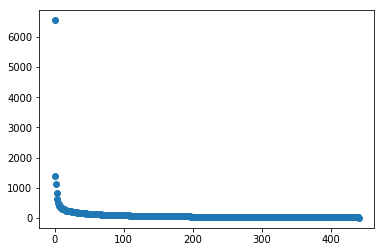

In [8]:
fig, ax = plt.subplots()
ax.plot(ssteof.s, 'o')
ax.margins(0.05)

[84.07978743  3.77388359  2.47523158  1.32741032  0.80666485  0.50680274
  0.42458736  0.31183881  0.26501981  0.23909147]


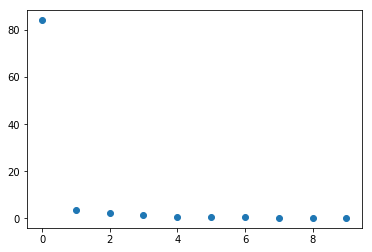

In [9]:
fig, ax = plt.subplots()
ax.plot(ssteof.percent_var()[:10], 'o')
print(ssteof.percent_var()[:10])

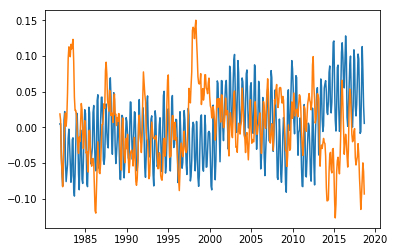

In [10]:
fig, ax = plt.subplots()
ax.plot(yeartime, ssteof.u[:, 5:7])

We now take the reshaped spatial patterns, mask them with the landmask, undo the latitude weighting, and multiply them by the singular values.

In [11]:
pats = np.ma.array(ssteof.v_reshaped)
pats[:, landmask] = np.ma.masked
pats /= latweights
pats = pats *  ssteof.s[:, np.newaxis, np.newaxis]

In [12]:
cmap = plt.get_cmap('RdBu_r')

Now make a quick contour plot of the spatial pattern, without bothering to use a map projection.

In [13]:
# quick and dirty: using global pats and ssteof
def contour_pattern(i):
    # normalize so that std of time function is unity, and pattern
    # is in degrees.
    std_t = ssteof.u[:, i].std()
    pat = pats[i] * std_t
    mag = pat.std()
    cticker = mpl.ticker.MaxNLocator(nbins=30, symmetric=True)
    cticker.create_dummy_axis()
    cticker.set_bounds(-2*mag, 2*mag)
    clevs = cticker()

    fig, ax = plt.subplots()
    cs = ax.contourf(lon, lat, pat, levels=clevs,
                 cmap=cmap,
                 extend='both')
    ax.patch.set_facecolor('gray')
    fig.colorbar(cs, ax=ax, shrink=0.9)

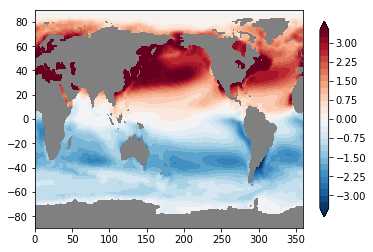

In [14]:
contour_pattern(0)

Last, let's make a nicer plot for each of the first few EOFs, with a map for the spatial pattern.

In [15]:
gmap = Basemap(lon_0=180, projection="kav7", resolution='c')
X, Y = gmap(*np.meshgrid(lon, lat))
def draw_map(gmap, ax):
    gmap.drawmapboundary(ax=ax)
    gmap.drawcoastlines(ax=ax)
    gmap.fillcontinents(ax=ax)
    gmap.drawmeridians(np.arange(0, 360.01, 30), ax=ax)
    gmap.drawparallels(np.arange(-60, 60.01, 30), ax=ax)



In [16]:
def map_pattern(i, pats, ssteof, yeartime, gmap):
    # normalize so that std of time function is unity, and pattern
    # is in degrees.
    std_t = ssteof.u[:, i].std()
    pat = pats[i] * std_t
    mag = pat.std()
    cticker = mpl.ticker.MaxNLocator(nbins=30, symmetric=True)
    cticker.create_dummy_axis()
    cticker.set_bounds(-2*mag, 2*mag)
    clevs = cticker()

    #fig, ax = plt.subplots()
    #cs = ax.contourf(lon, lat, pat, levels=clevs,
    #             cmap=cmap,
    #             extend='both')
    #fig.colorbar(cs, ax=ax, shrink=0.9)

    fig, axs = plt.subplots(nrows=2, figsize=(7, 10))
    
    draw_map(gmap, ax=axs[1])
    cs = gmap.contourf(X, Y, pat, levels=clevs, 
                   cmap=cmap,
                   extend='both', ax=axs[1])
    cbar = fig.colorbar(cs, ax=axs[1], orientation='vertical',
                        shrink=0.8,
                        ticks=plt.MaxNLocator(nbins=6, symmetric=True))
    cbar.set_label('$^\circ$C')
    ax = axs[0]
    ax.plot(yeartime, ssteof.u[:, i] / std_t)
    ax.set_title("EOF %d: %.1f%% of variance" % 
                 (i, ssteof.percent_var()[i]))
    

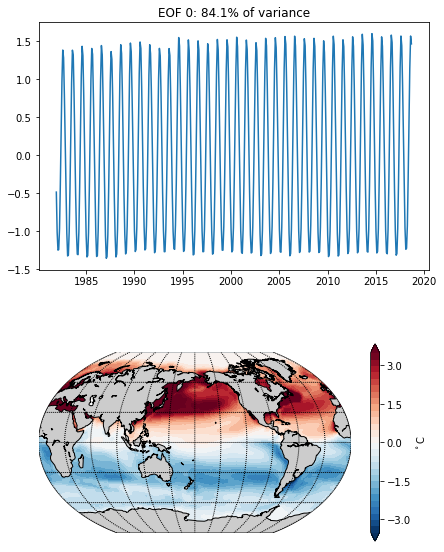

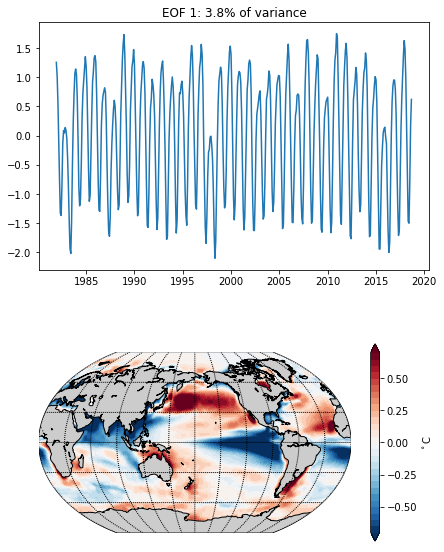

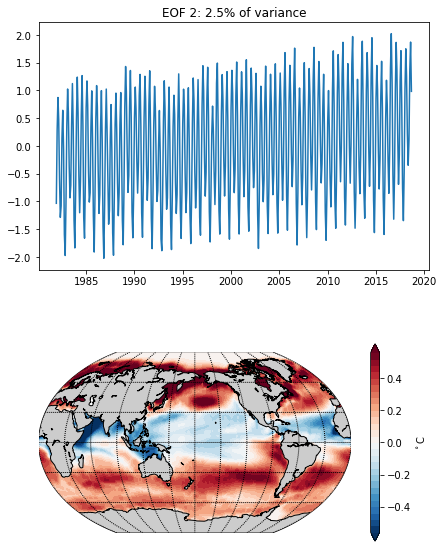

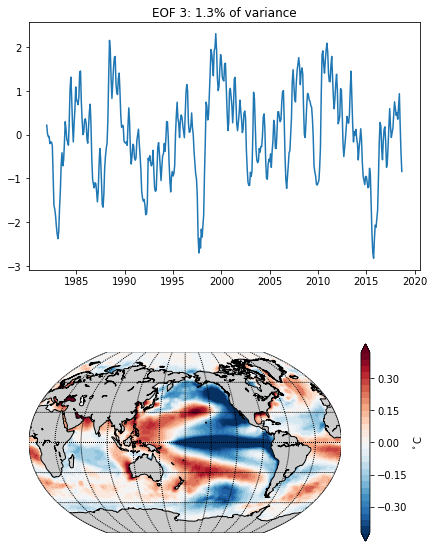

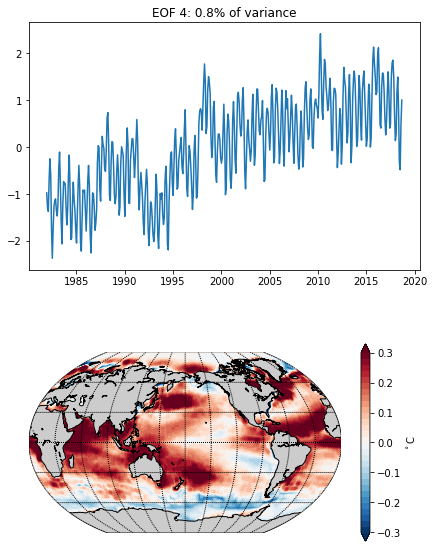

In [17]:
for i in range(5):
    map_pattern(i, pats, ssteof, yeartime, gmap)
